![MLA Logo](https://drive.corp.amazon.com/view/mrruckma@/MLA_headerv2.png?download=true)

### 1. Download and Read the Dataset

## Thank You's 
#### A special thank you to [Petar Butkovic, InTech](https://phonetool.amazon.com/users/petarb) and [Nisha Menon, Hyd Ops](https://phonetool.amazon.com/users/nisham) for building this dataset

#### Our dataset is made of Amazon product images. We have 5 categories: "Ring", "Shirt", "Watch", "Jeans" and "Shoe".
![Images](https://drive.corp.amazon.com/view/cesazara@/cv-notebook-images/product_images.png?download=true)

#### We have the following classes:
### * Class 0: Inconclusive
### * Class 1: Two Wheels
### * Class 2: Four Wheels
### * Class 3: Not Luggage
### * Class 4: Zero Wheels

Let's download the dataset from our S3 bucket into Eider. 

In [1]:

import pickle
import boto3
import pandas as pd

s3 = boto3.client('s3')

s3.download_file('clcar-ml', 'test_data.pkl', 'test_data.pkl')
df_test = pd.read_pickle('test_data.pkl')
print("Done reading Test Data")

s3.download_file('clcar-ml', 'training_data.pkl', 'training_data.pkl')
df_train = pd.read_pickle('training_data.pkl')

print("Done reading Training Data")






Done reading Test Data
Done reading Training Data


We are reading it into a Data Frame. 

In [2]:


print(len(df_train.index))
print(df_test.head(10))

1796
     ID                                               data
0  1453  [[[255, 255, 255], [255, 255, 255], [255, 255,...
1   655  [[[255, 255, 255], [255, 255, 255], [255, 255,...
2  1178  [[[255, 255, 255], [255, 255, 255], [255, 255,...
3   548  [[[255, 255, 255], [255, 255, 255], [255, 255,...
4  1547  [[[255, 255, 255], [255, 255, 255], [255, 255,...
5  1712  [[[255, 255, 255], [255, 255, 255], [255, 255,...
6  1685  [[[255, 255, 255], [255, 255, 255], [255, 255,...
7  1095  [[[255, 255, 255], [255, 255, 255], [255, 255,...
8   138  [[[255, 255, 255], [255, 255, 255], [255, 255,...
9   754  [[[255, 255, 255], [255, 255, 255], [255, 255,...


Sample of images

In [3]:
#Let's see what kind of data we're working with
import matplotlib.pyplot as plt

plt.imshow(df_train['data'][805])
plt.show()
plt.imshow(df_train['data'][807])
plt.show()
plt.imshow(df_train['data'][95])
plt.show()
plt.imshow(df_train['data'][202])
plt.show()
plt.imshow(df_test['data'][91])
plt.show()



<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

Let's plot some images below.

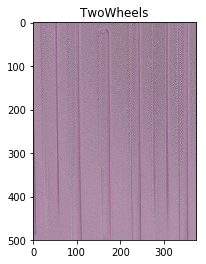

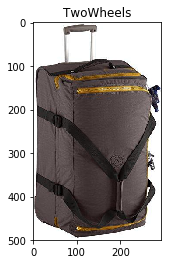

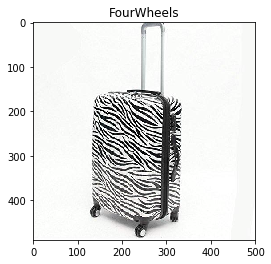

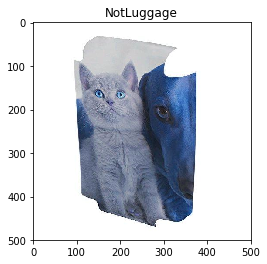

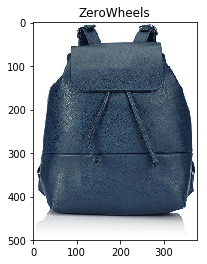

In [4]:
import matplotlib.pyplot as plt

classes = ['Inconclusive', 'TwoWheels', 'FourWheels', 'NotLuggage', 'ZeroWheels']

plt.imshow(df_train["data"][805])
plt.title(classes[df_train["label"][805]])
plt.show()

plt.imshow(df_train["data"][807])
plt.title(classes[df_train["label"][807]])
plt.show()

plt.imshow(df_train["data"][95])
plt.title(classes[df_train["label"][95]])
plt.show()

plt.imshow(df_train["data"][202])
plt.title(classes[df_train["label"][202]])
plt.show()

plt.imshow(df_train["data"][91])
plt.title(classes[df_train["label"][91]])
plt.show()

### 2. Split the dataset and Process Images
#### * We split the original dataset into Training (80%), Validation (10%) and Test (10%) subsets. 
#### * We will process images by resizing to 224x224 and converting (row, column, channel) to (channel, row, column)

In [5]:
import numpy as np
from skimage.transform import resize
print("Length of index")
print(len(df_test.index))
print(len(df_train.index))

# Let's split to data into training (80%), validation (10%) and test (10%) subsets.
train_indices = np.arange(0, int(0.8*len(df_train.index)))
val_indices = np.arange(int(0.8*len(df_train)), len(df_train.index))
test_indices = np.arange(0, len(df_test.index))

train_df = df_train.iloc[train_indices]
val_df = df_train.iloc[val_indices]
test_df = df_test.iloc[test_indices]

del df_train
del df_test

def getImages(images):
    # Create the image holder array
    image_arr = np.zeros((images.shape[0], 3, 224, 224))
    
    # Iterate through the image data
    for i, im in enumerate(images):
        # Get image from the data column of the current row
        
        # We need a fixed size input, our images have different sizes, let's pick 224x224.
        # Resize image below
        im = resize(im, output_shape=(224, 224), mode='constant')
        
        # Gluon/mxnet expects images in this format (channel, row, column)
        # This is the opposite of (row, column, channel), let's fix it
        im = np.moveaxis(im, -1, 0)
        
        # Assign the value in the image array
        image_arr[i] = im

    return image_arr
    
train_images, train_labels = getImages(train_df["data"].values), train_df["label"].values
validation_images, validation_labels = getImages(val_df["data"].values), val_df["label"].values

Length of index
449
1796


### 3. Plot the class distribution

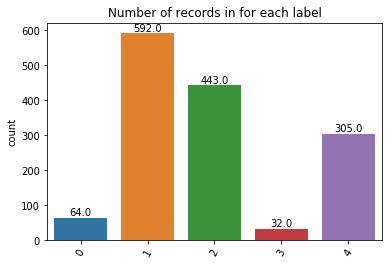

In [6]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure()
ax = sb.countplot(x=train_labels, y = None)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate(y, (x.mean(), y), ha='center', va='bottom') 
plt.xticks(rotation=60)
plt.title('Number of records in for each label')
plt.show()

### 4. Confusion Matrix 
#### We have the following function to plot confusion matrix. We will call this function to plot confusion matrix for our validation data after each epoch (one full pass through the training dataset)


In [7]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index = [i for i in ['Inconclusive', 'Two Wheels', 'Four Wheels', 'Not Luggage', 'Zero Wheels']], columns = [i for i in ['Inconclusive', 'Two Wheels', 'Four Wheels', 'Not Luggage', 'Zero Wheels']])
    plt.figure(figsize = (5, 5))
    plt.title('Validation Confusion Matrix')
    sn.heatmap(df_cm, annot=True)
    plt.show()

### 5. Training and Validation
#### We will do the following:
#### * Create a simple Convolutional Neural Network (2 conv-pool pairs + flattening + softmax)
#### * Use the following hyper-parameters: batch size, epochs, learning rate. You can experiment with different values, but we will discuss those in greater detail tomorrow
#### * Calculate the loss and accuracy for training and validation at each epoch and print them at the end of each epoch.
#### * Plot the confusion matrix at the end of each epoch. 

Define loss.
Define trainer.
Epoch 0, training loss: 0.85, validation loss: 0.67, training accuracy: 0.65, validation accuracy: 0.74


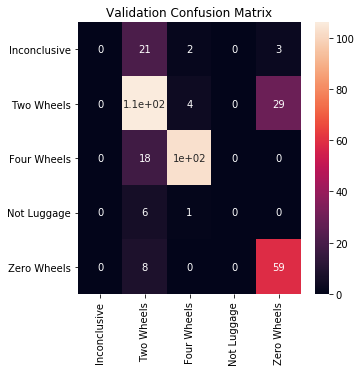

Epoch 1, training loss: 0.61, validation loss: 0.67, training accuracy: 0.75, validation accuracy: 0.75


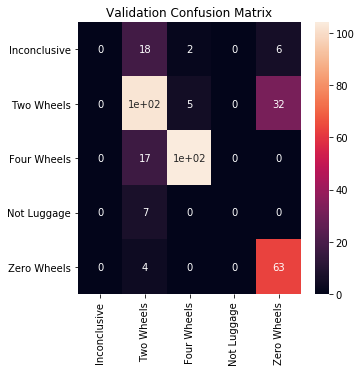

Epoch 2, training loss: 0.66, validation loss: 0.67, training accuracy: 0.75, validation accuracy: 0.74


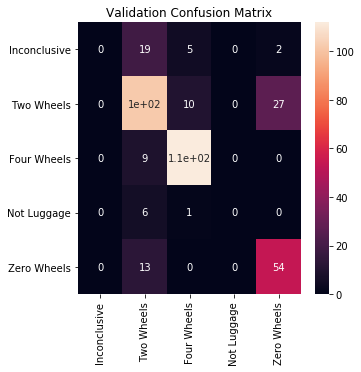

Epoch 3, training loss: 0.78, validation loss: 1.00, training accuracy: 0.69, validation accuracy: 0.58


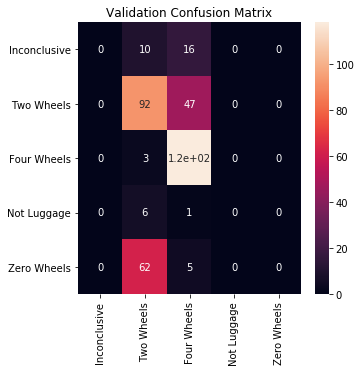

Epoch 4, training loss: 0.93, validation loss: 1.16, training accuracy: 0.63, validation accuracy: 0.42


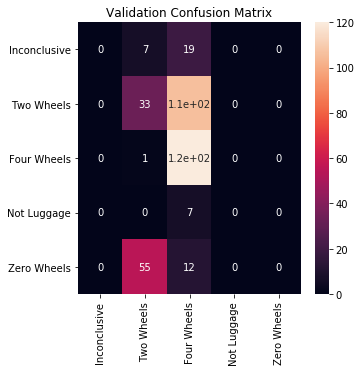

Epoch 5, training loss: 1.06, validation loss: 1.20, training accuracy: 0.57, validation accuracy: 0.47


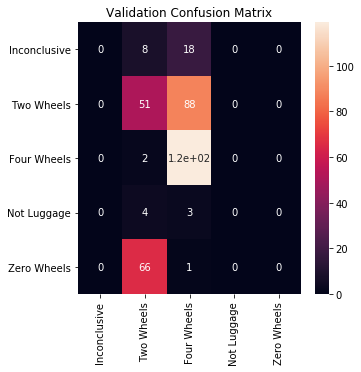

Epoch 6, training loss: 1.09, validation loss: 1.11, training accuracy: 0.57, validation accuracy: 0.59


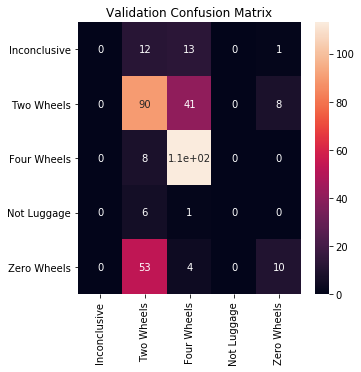

Epoch 7, training loss: 1.18, validation loss: 1.20, training accuracy: 0.53, validation accuracy: 0.64


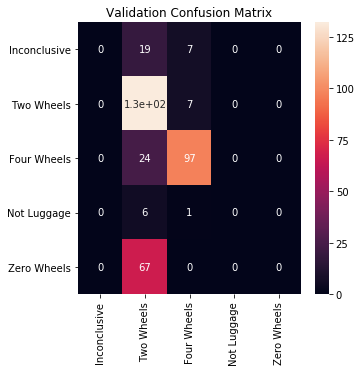

Epoch 8, training loss: 1.22, validation loss: 1.27, training accuracy: 0.47, validation accuracy: 0.46


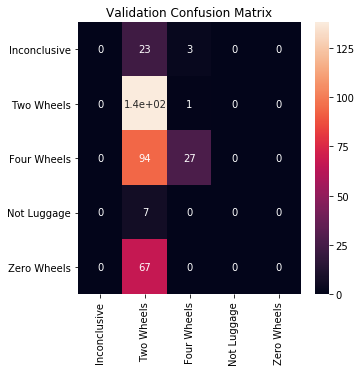

Epoch 9, training loss: 1.27, validation loss: 1.31, training accuracy: 0.43, validation accuracy: 0.39


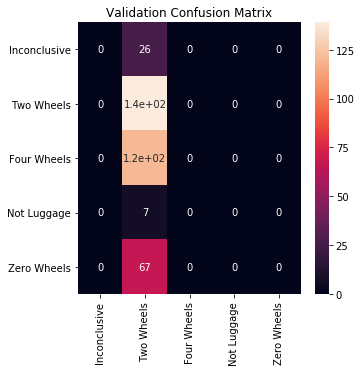

Epoch 10, training loss: 1.29, validation loss: 1.33, training accuracy: 0.41, validation accuracy: 0.39


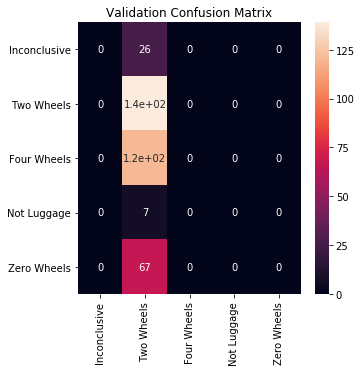

Epoch 11, training loss: 1.30, validation loss: 1.33, training accuracy: 0.41, validation accuracy: 0.39


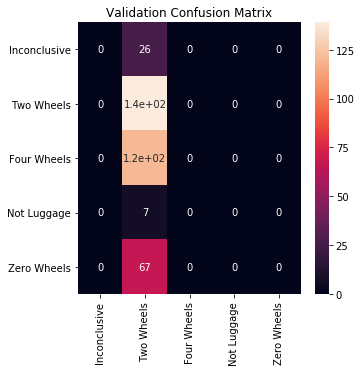

Epoch 12, training loss: 1.30, validation loss: 1.33, training accuracy: 0.41, validation accuracy: 0.39


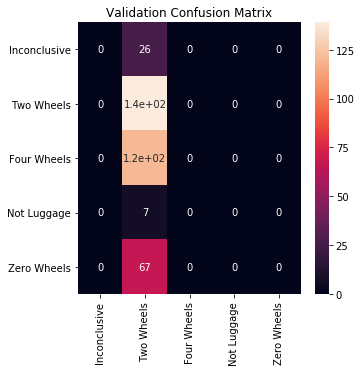

Epoch 13, training loss: 1.30, validation loss: 1.33, training accuracy: 0.41, validation accuracy: 0.39


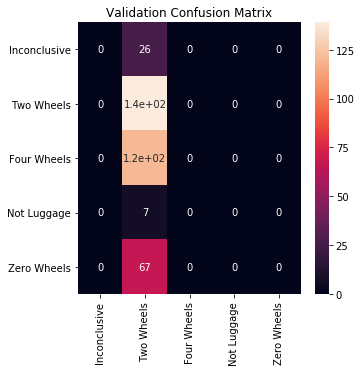

Epoch 14, training loss: 1.30, validation loss: 1.34, training accuracy: 0.41, validation accuracy: 0.39


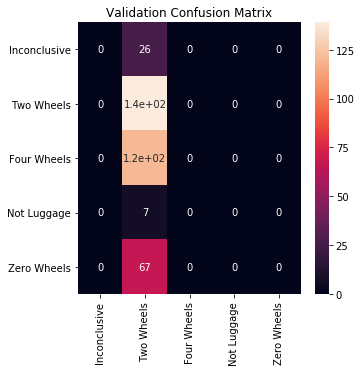

Epoch 15, training loss: 1.31, validation loss: 1.34, training accuracy: 0.41, validation accuracy: 0.39


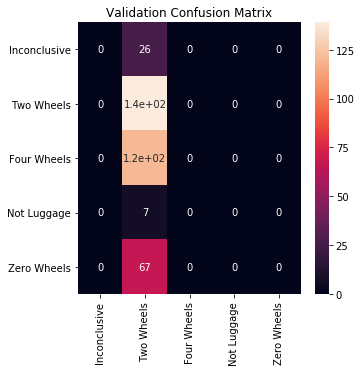

Epoch 16, training loss: 1.31, validation loss: 1.34, training accuracy: 0.41, validation accuracy: 0.39


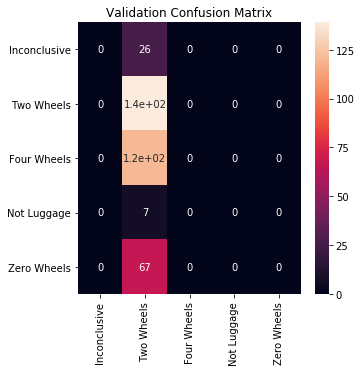

Epoch 17, training loss: 1.31, validation loss: 1.34, training accuracy: 0.41, validation accuracy: 0.39


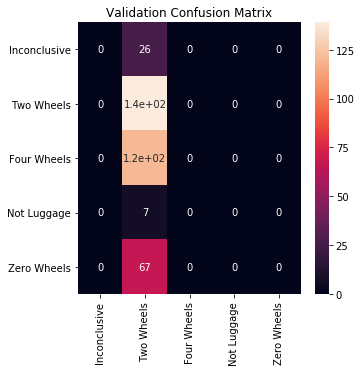

Epoch 18, training loss: 1.31, validation loss: 1.34, training accuracy: 0.41, validation accuracy: 0.39


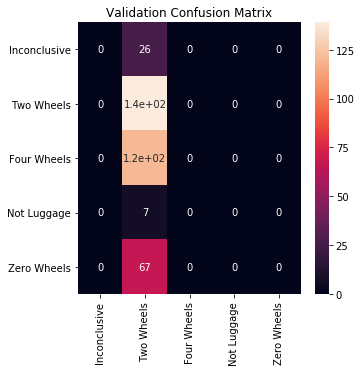

Epoch 19, training loss: 1.31, validation loss: 1.34, training accuracy: 0.41, validation accuracy: 0.39


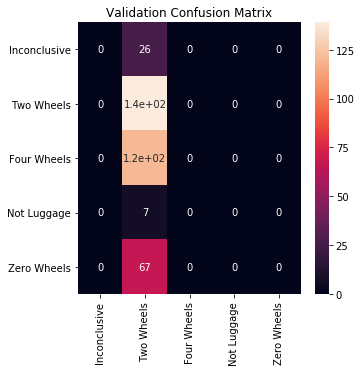

Epoch 20, training loss: 1.31, validation loss: 1.34, training accuracy: 0.41, validation accuracy: 0.39


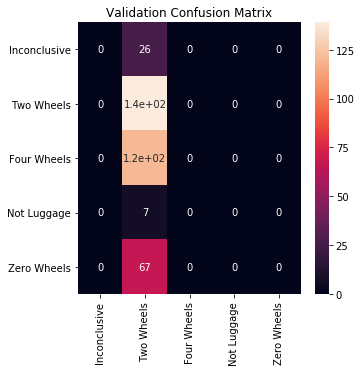

Epoch 21, training loss: 1.31, validation loss: 1.34, training accuracy: 0.41, validation accuracy: 0.39


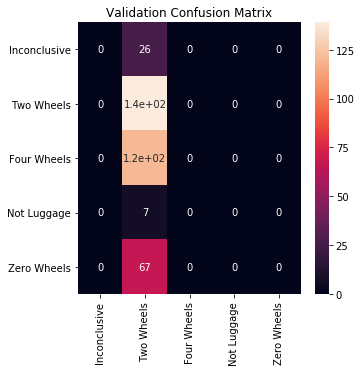

Epoch 22, training loss: 1.31, validation loss: 1.34, training accuracy: 0.41, validation accuracy: 0.39


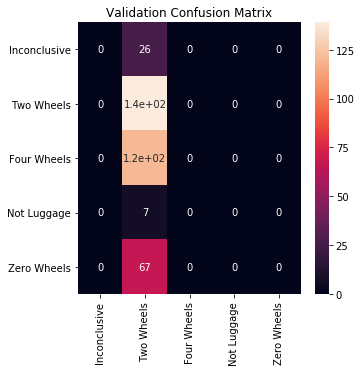

Epoch 23, training loss: 1.31, validation loss: 1.34, training accuracy: 0.41, validation accuracy: 0.39


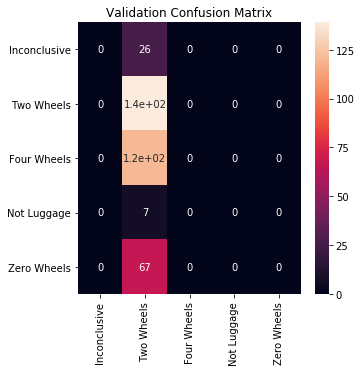

Epoch 24, training loss: 1.31, validation loss: 1.34, training accuracy: 0.41, validation accuracy: 0.39


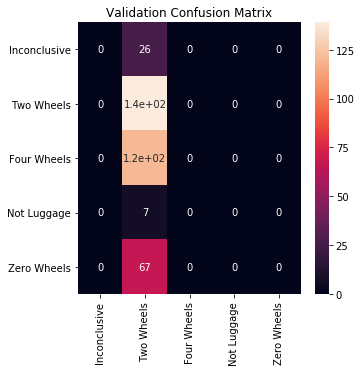

In [8]:
from mxnet.gluon.model_zoo import vision

import mxnet as mx

def build_network(num_outputs):
    # Set this to GPU or CPU
    ctx = mx.gpu()
    #ctx = mx.cpu()
 
    # Get the pre-trained network
    pre_trained_net = vision.vgg19(pretrained=True, ctx=ctx)
 
    # Get the non-trained network
    net = vision.vgg19(classes=num_outputs, ctx=ctx)
    
    # Initialize weights
    #net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
    net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

    # Copy weights from the trained network
    net.features = pre_trained_net.features
 
    return net

from mxnet import gluon, autograd, ndarray
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss
import mxnet.ndarray as nd
from sklearn.metrics import accuracy_score

# Set this to CPU or GPU depending on your training instance
# ctx = mx.cpu()
ctx = mx.gpu()

# Hyper-paramaters of the system
#batch_size = 150
#epochs = 30

batch_size = 32
epochs = 25

#learning_rate = 0.01

# Create the network. We have 5 classes
num_outputs = 5
    
#net = gluon.nn.Sequential()

net = build_network(num_outputs)

# Get the pre-trained network
#pre_trained_net = vision.vgg16(pretrained=True, ctx=ctx)

# Get the non-trained network
#net = vision.vgg16(classes=num_outputs, ctx=ctx)

# Copy weights from the trained network
#net.features = pre_trained_net.features

# with net.name_scope():
#     net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
#     net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
#     net.add(gluon.nn.Conv2D(channels=60, kernel_size=3, activation='relu'))
#     net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
#     # The Flatten layer collapses all axis, except the first one, into one axis.
#     net.add(gluon.nn.Flatten())
#     net.add(gluon.nn.Dense(512, activation="relu"))
#     net.add(gluon.nn.Dense(num_outputs))
    
# Initialize parameters
#net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

# Initialize weights
#net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
 


print("Define loss.")
softmax_cross_etropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()

print("Define trainer.")
trainer = gluon.Trainer(net.collect_params(), 'nag', {'learning_rate': 0.01, 'momentum': 0.1, 'wd':0.3})

# Starting the outer loop, we will have 30 epochs (30 full pass through our dataset)
for epoch in range(epochs):
    
    # Training loop: (with autograd and trainer steps, etc.)
    # This loop does the training of the neural network (weights are updated)
    cumulative_train_loss = 0
    train_predictions = []
    for i in range(0, train_images.shape[0], batch_size):
        data = nd.array(train_images[i:i + batch_size].astype('float32')).as_in_context(ctx)
        label = nd.array(train_labels[i:i + batch_size]).as_in_context(ctx)
        with autograd.record():
            output = net(data)
            train_predictions = train_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
            loss = softmax_cross_etropy_loss(output, label)
            cumulative_train_loss = cumulative_train_loss + nd.sum(loss)
        loss.backward()
        trainer.step(data.shape[0])
    
    # Calculating the Softmax Cross Entopy Loss for training
    train_loss = cumulative_train_loss/len(train_images)

    # Validation loop:
    # This loop tests the trained network on validation dataset
    # No weight updates here
    cumulative_valid_loss = 0
    val_predictions = []
    for i in range(0, validation_images.shape[0], batch_size):
        data = nd.array(validation_images[i:i + batch_size].astype('float32')).as_in_context(ctx)
        label = nd.array(validation_labels[i:i + batch_size]).as_in_context(ctx)
        output = net(data)
        val_predictions = val_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
        val_loss = softmax_cross_etropy_loss(output, label)
        cumulative_valid_loss = cumulative_valid_loss + nd.sum(val_loss)
    valid_loss = cumulative_valid_loss/len(validation_images)

    # Calculate training and validation accuracies
    # I used a accuracy_score() function from the sklearn library here. 
    # accuracy = (TP+TN) / (TP+FP+TN+FN)
    train_accuracy = accuracy_score(train_labels.tolist(), train_predictions)
    validation_accuracy = accuracy_score(validation_labels.tolist(), val_predictions)
    
    # Print the summary and plot the confusion matrix after each epoch
    print("Epoch {}, training loss: {:.2f}, validation loss: {:.2f}, training accuracy: {:.2f}, validation accuracy: {:.2f}".format(epoch, train_loss.asnumpy()[0], valid_loss.asnumpy()[0], train_accuracy, validation_accuracy))
    plot_confusion_matrix(validation_labels.tolist(), val_predictions)

### 6. Test on test dataset
#### We are done with the training and validation. Let's get the test predictions below. We will also write them to a __CSV__ file in a similar way to our __Final Project__. 

In [9]:
test_images = getImages(test_df["data"].values)
test_predictions = []
for i in range(0, test_images.shape[0], batch_size):
    data = nd.array(test_images[i:i + batch_size].astype('float32')).as_in_context(ctx)
    output = net(data)
    test_predictions = test_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
print(test_predictions)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [10]:
import pandas as pd

result_df = pd.DataFrame(columns=['ID', 'label'])
result_df["ID"] = test_df["ID"]
result_df["label"] = test_predictions

result_df.to_csv("results_cv_example_clcar-vggnet.csv", index=False)
result_df.head(20)

s3.upload_file('results_cv_example_clcar-vggnet.csv', 'clcar-ml', 'results_cv_example_clcar-vggnet.csv')